In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math

In [3]:
%matplotlib inline
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

## Spectrum Analysis $\Rightarrow$ Linear Landau Damping 

In [18]:
# number of Hermite moments
Nv = 1000

In [19]:
def factorial_ratio(num1, denom1, num2, denom2):
    # return (num1!num2!) / (denom1!denom2!) with num1>denom1 and num2<denom2
    vector1 = range(denom1 + 1, num1 + 1)
    vector2 = range(num2 + 1, denom2 + 1)
    const = 1
    for ii in range(len(vector1)):
        const *= vector1[ii]/ vector2[ii]
    return const

In [20]:
def A_advection(Nv, k):
    # advection matrix with off-diagonal entries
    # intialize off-diagonal vector
    vec = np.zeros(Nv-1, dtype="complex128")
    for jj in range(1, Nv):
        vec[jj-1] = np.sqrt(jj)
    # set up tri-diagonal matrix
    A = np.diag(vec, 1) + np.diag(vec, -1) 
    # wave-particle interaction term
    A[1, 0] += 1 / k**2 
    return A

def damping_rate(mat):
    # return least damped mode (gamma) s.t. lambda = gamma + i * omega
    # eigenvalue decomposition
    eig, _= np.linalg.eig(mat)
    # return the least damped mode rate
    if np.max(eig.real) <= 0:
        return np.max(eig.real)
    else:
        print("we have an instability", np.max(eig.real))
    
def Hypercollisions_eig(k, nu, Nv, alpha=1):
    # Hypercollisional operator 
    A = A_advection(Nv=Nv, k=k)
    # advection matrix (main-diagonal)
    vec2 = np.zeros(Nv)
    for jj in range(0, Nv):
        # hyper collisions coefficient
        vec2[jj] = factorial_ratio(num1=jj, denom1=jj-2*alpha+1, num2=Nv - 2*alpha, denom2=Nv -1)
    A =  A + np.diag(nu*vec2 / (1j*k), 0)
    return damping_rate(mat=-1j * k * A)

def HouLi_eig(k, nu, Nv, alpha=36):
    # Hypercollisional operator 
    A = A_advection(Nv=Nv, k=k)
    # advection matrix (main-diagonal)
    vec2 = np.zeros(Nv)
    for jj in range(0, Nv):
        # hyper collisions coefficient
        vec2[jj] = (jj/(Nv-1))**alpha
    A =  A + np.diag(nu*vec2 / (1j*k), 0)
    return damping_rate(mat=-1j * k * A)

def HammetPerkins_eig(k, nu, Nv):
    # Hammet Perkins esque (like) operator 
    # C(C_{Nv-1}) = i * nu * k/|k| * C_{Nv-1}
    A = A_advection(Nv=Nv, k=k)
    A[-1, -1] = - nu * 1j * np.sqrt(Nv) * k / np.abs(k) 
    return damping_rate(mat=-1j * k * A)

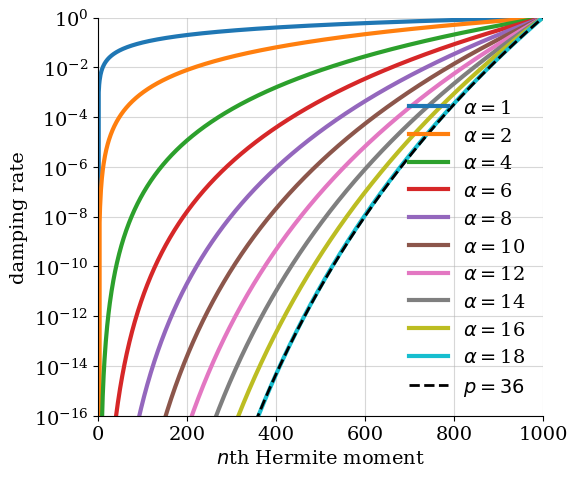

In [23]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 5))
for alpha in np.append(1, range(2, 20, 2)):
    vec2 = np.zeros(Nv)
    for jj in range(2*alpha-1, Nv):
        # hyper collisions coefficient
        vec2[jj] = factorial_ratio(num1=jj, denom1=jj-2*alpha+1, num2=Nv - 2*alpha, denom2=Nv -1)
    plt.plot(vec2, label=r"$\alpha=$"+str(alpha), linewidth=3)

vec2 = np.zeros(Nv)
for jj in range(0, Nv):
    # hyper collisions coefficient
    vec2[jj] = (jj/(Nv-1))**36
plt.plot(vec2, label=r"$p=36$", linewidth=2, color="black", ls="--")


ax.set_yscale("log")
ax.set_ylim(1e-16, 1)
#ax.set_xticks([0, 5, 10, 15, 20])
#ax.set_xticklabels([0, 5, 10, 15, 20])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("$n$th Hermite moment")
ax.set_ylabel(r"damping rate")
legend = ax.legend(ncols=1, fancybox=False, shadow=False,  loc="lower right")
legend.get_frame().set_alpha(0)
ax.set_xlim(0, Nv)

plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig("figs/hypercollisional_damping_rate_" + str(Nv) + ".png", dpi=200, bbox_inches='tight')

1.0163163163163162
1.0163163163163162


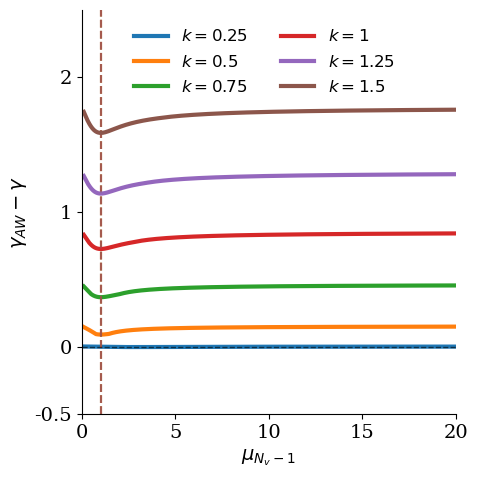

In [8]:
fig, ax = plt.subplots(ncols=1, figsize=(5, 5))

# vector of possible closure parameters 
nu_LC = np.linspace(1E-1, 20, 1000)

eig_LC = np.zeros(len(nu_LC))
for ii, nu in enumerate(nu_LC):
    eig_LC[ii] = HammetPerkins_eig(k=0.25, nu=nu, Nv=Nv) 
#ax.axvline(nu_LC[np.argmin(np.abs(eig_LC + 0.00216))], color="tab:blue", alpha=0.6, ls="--")
ax.plot(nu_LC, eig_LC + 0.00216, color="tab:blue", label="$k=0.25$", linewidth=3)

eig_LC = np.zeros(len(nu_LC))
for ii, nu in enumerate(nu_LC):
    eig_LC[ii] = HammetPerkins_eig(k=0.5, nu=nu, Nv=Nv)
ax.axvline(nu_LC[np.argmin(np.abs(eig_LC + 0.1533))], color="tab:orange", alpha=0.6, ls="--")
print(nu_LC[np.argmin(np.abs(eig_LC + 0.1533))])
ax.plot(nu_LC, eig_LC + 0.1533, color="tab:orange", label="$k=0.5$", linewidth=3)

eig_LC = np.zeros(len(nu_LC))
for ii, nu in enumerate(nu_LC):
    eig_LC[ii] = HammetPerkins_eig(k=0.75, nu=nu, Nv=Nv) 
ax.axvline(nu_LC[np.argmin(np.abs(eig_LC + 0.461918))], color="tab:green", alpha=0.6, ls="--")
ax.plot(nu_LC, eig_LC + 0.461918, color="tab:green", label="$k=0.75$", linewidth=3)

eig_LC = np.zeros(len(nu_LC))
for ii, nu in enumerate(nu_LC):
    eig_LC[ii] = HammetPerkins_eig(k=1, nu=nu, Nv=Nv) 
ax.axvline(nu_LC[np.argmin(np.abs(eig_LC + 0.8513))], color="tab:red", alpha=0.6, ls="--")
ax.plot(nu_LC, eig_LC + 0.8513, color="tab:red", label=r"$k=1$", linewidth=3)


eig_LC = np.zeros(len(nu_LC))
for ii, nu in enumerate(nu_LC):
    eig_LC[ii] = HammetPerkins_eig(k=1.25, nu=nu, Nv=Nv) 
ax.axvline(nu_LC[np.argmin(np.abs(eig_LC + 1.29386))], color="tab:purple", alpha=0.2, ls="--")
ax.plot(nu_LC, eig_LC + 1.29386, color="tab:purple", label=r"$k=1.25$", linewidth=3)


eig_LC = np.zeros(len(nu_LC))
for ii, nu in enumerate(nu_LC):
    eig_LC[ii] = HammetPerkins_eig(k=1.5, nu=nu, Nv=Nv) 
ax.axvline(nu_LC[np.argmin(np.abs(eig_LC + 1.7757))], color="tab:brown", alpha=0.2, ls="--")
print(nu_LC[np.argmin(np.abs(eig_LC + 1.7757))])
ax.plot(nu_LC, eig_LC + 1.7757, color="tab:brown", label=r"$k=1.5$", linewidth=3)


ax.axhline(0, ls="--", color="black", linewidth=1, alpha=0.6)
ax.set_xlabel(r"$\mu_{N_{v}-1}$")
ax.set_ylabel(r"$\gamma_{AW} - \gamma$")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(-1/2, 2.5)
ax.set_yticks([-0.5, 0, 1, 2])
ax.set_yticklabels([-0.5, 0, 1, 2])
ax.set_xlim(0, np.max(nu_LC))
legend = ax.legend(ncols=2, fancybox=False, shadow=False, bbox_to_anchor=(0.1, 0.75))
legend.get_frame().set_alpha(0)
#ax.text(np.mean(nu_LC)/2, 1.5, 'underdamped', fontsize=12, ha='center', va='center')
#ax.text(np.mean(nu_LC)/2, -0.5, 'overdamped', fontsize=12, ha='center', va='center')
plt.tight_layout()

plt.savefig("figs/spectra/optimal_HP_nu_postive_k_Nv_" + str(Nv) + ".png", dpi=200, bbox_inches='tight')

0.705705705801001
6.306306306364264


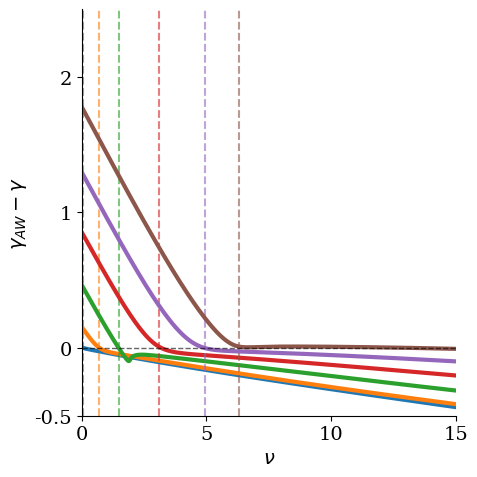

In [9]:
alpha=1
nu_HP = np.linspace(1e-10,15, 1000)

fig, ax = plt.subplots(ncols=1, figsize=(5, 5))

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=0.25, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.argmin(np.abs(eig_LB + 0.00216))], color="tab:blue", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 0.00216, color="tab:blue", linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=0.5, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.argmin(np.abs(eig_LB + 0.1533))], color="tab:orange", alpha=0.6, ls="--")
print(nu_HP[np.argmin(np.abs(eig_LB + 0.1533))])
ax.plot(nu_HP, eig_LB + 0.1533, color="tab:orange", linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=0.75, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.argmin(np.abs(eig_LB + 0.461918))], color="tab:green", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 0.461918, color="tab:green",  linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=1, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.min(np.where(np.abs(eig_LB + 0.8513) < 1e-2))], color="tab:red", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 0.8513, color="tab:red", linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=1.25, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.argmin(np.abs(eig_LB + 1.29386))], color="tab:purple", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 1.29386, color="tab:purple",linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=1.5, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.min(np.where(np.abs(eig_LB + 1.7757) < 1e-2))], color="tab:brown", alpha=0.6, ls="--")
print(nu_HP[np.min(np.where(np.abs(eig_LB + 1.7757) < 1e-2))])
ax.plot(nu_HP, eig_LB + 1.7757, color="tab:brown", linewidth=3)

ax.axhline(0, ls="--", color="black", linewidth=1, alpha=0.6)
ax.set_xlabel(r"$\nu$")
ax.set_yticks([-0.5, 0, 1, 2])
ax.set_yticklabels([-0.5, 0, 1, 2])
ax.set_ylabel(r"$\gamma_{AW} - \gamma $")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(-0.5, 2.5)
ax.set_xticks([0, 5, 10, 15])

ax.set_xlim(np.min(nu_HP), np.max(nu_HP))
#legend = ax.legend(ncols=2, fancybox=False, shadow=False, fontsize=12,  bbox_to_anchor=(0.1, 1.))
#legend.get_frame().set_alpha(0)

plt.tight_layout()


plt.savefig("figs/spectra/optimal_hypercollisions_" + str(alpha) + "_nu_positive_k_Nv_" + str(Nv) + ".png", dpi=200, bbox_inches='tight')

1.761051051051051
16.77006006006006


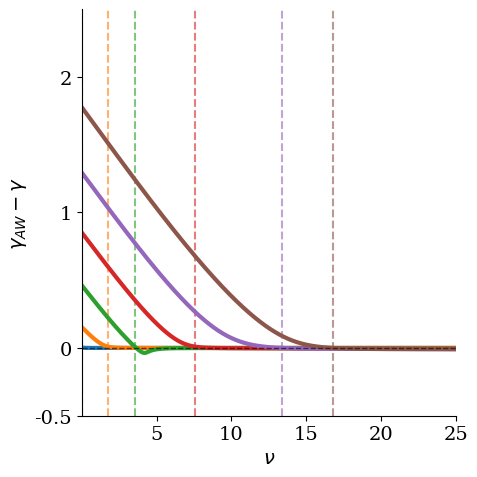

In [10]:
alpha=2
nu_HP = np.linspace(0.01, 25, 1000)

fig, ax = plt.subplots(ncols=1, figsize=(5, 5))

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=0.25, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.min(np.where(np.abs(eig_LB + 0.00216) < 1e-2))], color="tab:blue", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 0.00216, color="tab:blue", linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=0.5, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.min(np.where(np.abs(eig_LB + 0.1533) < 1e-2))], color="tab:orange", alpha=0.6, ls="--")
print(nu_HP[np.min(np.where(np.abs(eig_LB + 0.1533) < 1e-2))])
ax.plot(nu_HP, eig_LB + 0.1533, color="tab:orange", linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=0.75, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.min(np.where(np.abs(eig_LB + 0.461918) < 1e-2))], color="tab:green", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 0.461918, color="tab:green",  linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=1, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.min(np.where(np.abs(eig_LB + 0.8513) < 1e-2))], color="tab:red", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 0.8513, color="tab:red", linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=1.25, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.argmin(np.abs(eig_LB + 1.29386))], color="tab:purple", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 1.29386, color="tab:purple",linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=1.5, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.argmin(np.abs(eig_LB + 1.7757))], color="tab:brown", alpha=0.6, ls="--")
print(nu_HP[np.argmin(np.abs(eig_LB + 1.7757))])
ax.plot(nu_HP, eig_LB + 1.7757, color="tab:brown", linewidth=3)

ax.axhline(0, ls="--", color="black", linewidth=1, alpha=0.6)
ax.set_xlabel(r"$\nu$")
ax.set_yticks([-0.5, 0, 1, 2])
ax.set_ylabel(r"$\gamma_{AW} - \gamma $")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(-0.5, 2.5)
ax.set_yticklabels([-0.5, 0, 1, 2])

ax.set_xlim(np.min(nu_HP), np.max(nu_HP))
#legend = ax.legend(ncols=2, fancybox=False, shadow=False, fontsize=12,  bbox_to_anchor=(0.1, 1.))
#legend.get_frame().set_alpha(0)

plt.tight_layout()


plt.savefig("figs/spectra/optimal_hypercollisions_" + str(alpha) + "_nu_positive_k_Nv_" + str(Nv) + ".png", dpi=200, bbox_inches='tight')

2.7116216216216213
15.294174174174174


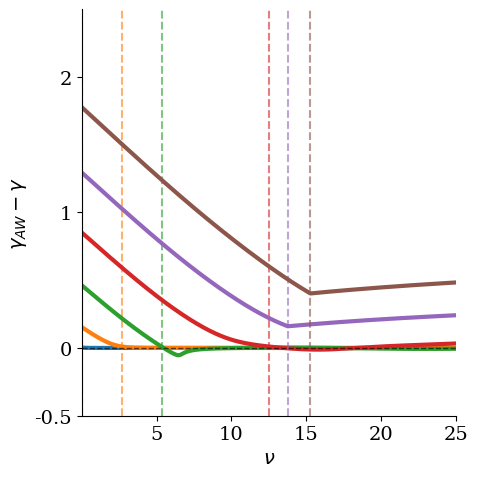

In [11]:
alpha=3
nu_HP = np.linspace(0.01, 25, 1000)

fig, ax = plt.subplots(ncols=1, figsize=(5, 5))

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=0.25, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.min(np.where(np.abs(eig_LB + 0.00216) < 1e-2))], color="tab:blue", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 0.00216, color="tab:blue", linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=0.5, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.min(np.where(np.abs(eig_LB + 0.1533) < 1e-2))], color="tab:orange", alpha=0.6, ls="--")
print(nu_HP[np.min(np.where(np.abs(eig_LB + 0.1533) < 1e-2))])
ax.plot(nu_HP, eig_LB + 0.1533, color="tab:orange", linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=0.75, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.min(np.where(np.abs(eig_LB + 0.461918) < 1e-2))], color="tab:green", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 0.461918, color="tab:green",  linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=1, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.min(np.where(np.abs(eig_LB + 0.8513) < 1e-2))], color="tab:red", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 0.8513, color="tab:red", linewidth=3)


eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=1.25, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.argmin(np.abs(eig_LB + 1.29386))], color="tab:purple", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 1.29386, color="tab:purple",linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=1.5, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.argmin(np.abs(eig_LB + 1.7757))], color="tab:brown", alpha=0.6, ls="--")
print(nu_HP[np.argmin(np.abs(eig_LB + 1.7757))])
ax.plot(nu_HP, eig_LB + 1.7757, color="tab:brown", linewidth=3)

ax.axhline(0, ls="--", color="black", linewidth=1, alpha=0.6)
ax.set_xlabel(r"$\nu$")
ax.set_yticks([-0.5, 0, 1, 2])
ax.set_yticklabels([-0.5, 0, 1, 2])
ax.set_ylabel(r"$\gamma_{AW} - \gamma $")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(-0.5, 2.5)

ax.set_xlim(np.min(nu_HP), np.max(nu_HP))
#legend = ax.legend(ncols=2, fancybox=False, shadow=False, fontsize=12,  bbox_to_anchor=(0.1, 1.))
#legend.get_frame().set_alpha(0)

plt.tight_layout()


plt.savefig("figs/spectra/optimal_hypercollisions_" + str(alpha) + "_nu_positive_k_Nv_" + str(Nv) + ".png", dpi=200, bbox_inches='tight')

3.662192192192192
13.618168168168168


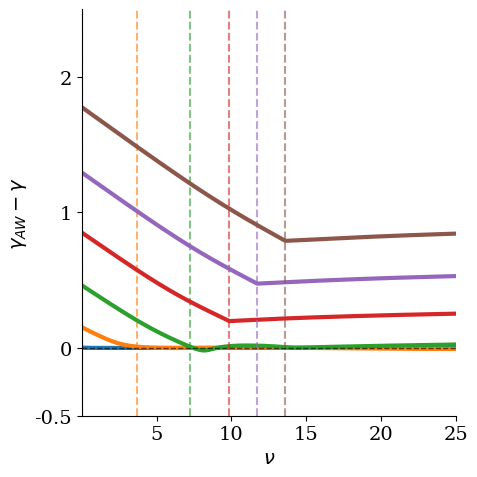

In [12]:
alpha=4
nu_HP = np.linspace(0.01, 25, 1000)

fig, ax = plt.subplots(ncols=1, figsize=(5, 5))

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=0.25, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.min(np.where(np.abs(eig_LB + 0.00216) < 1e-2))], color="tab:blue", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 0.00216, color="tab:blue", linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=0.5, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.min(np.where(np.abs(eig_LB + 0.1533) < 1e-2))], color="tab:orange", alpha=0.6, ls="--")
print(nu_HP[np.min(np.where(np.abs(eig_LB + 0.1533) < 1e-2))])
ax.plot(nu_HP, eig_LB + 0.1533, color="tab:orange", linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=0.75, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.min(np.where(np.abs(eig_LB + 0.461918) < 1e-2))], color="tab:green", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 0.461918, color="tab:green",  linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=1, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.argmin(np.abs(eig_LB + 0.8513))], color="tab:red", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 0.8513, color="tab:red", linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=1.25, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.argmin(np.abs(eig_LB + 1.29386))], color="tab:purple", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 1.29386, color="tab:purple",linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=1.5, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.argmin(np.abs(eig_LB + 1.7757))], color="tab:brown", alpha=0.6, ls="--")
print(nu_HP[np.argmin(np.abs(eig_LB + 1.7757))])
ax.plot(nu_HP, eig_LB + 1.7757, color="tab:brown", linewidth=3)

ax.axhline(0, ls="--", color="black", linewidth=1, alpha=0.6)
ax.set_xlabel(r"$\nu$")
ax.set_yticks([-0.5, 0, 1, 2])
ax.set_yticklabels([-0.5, 0, 1, 2])
ax.set_ylabel(r"$\gamma_{AW} - \gamma $")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(-0.5, 2.5)

ax.set_xlim(np.min(nu_HP), np.max(nu_HP))
#legend = ax.legend(ncols=2, fancybox=False, shadow=False, fontsize=12,  bbox_to_anchor=(0.1, 1.))
#legend.get_frame().set_alpha(0)

plt.tight_layout()


plt.savefig("figs/spectra/optimal_hypercollisions_" + str(alpha) + "_nu_positive_k_Nv_" + str(Nv) + ".png", dpi=200, bbox_inches='tight')

5.413243243243243
11.742042042042042


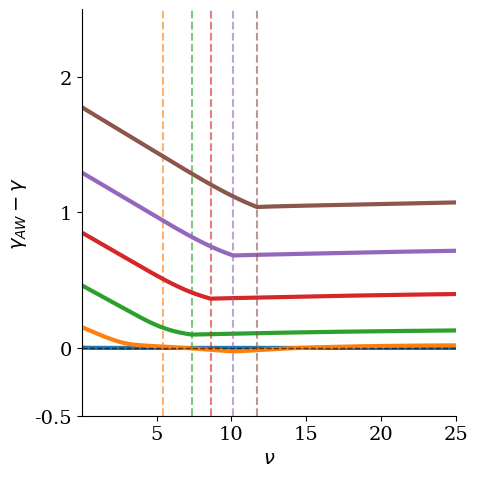

In [13]:
alpha=5
nu_HP = np.linspace(0.01, 25, 1000)

fig, ax = plt.subplots(ncols=1, figsize=(5, 5))

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=0.25, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.min(np.where(np.abs(eig_LB + 0.00216) < 1e-2))], color="tab:blue", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 0.00216, color="tab:blue", linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=0.5, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.min(np.where(np.abs(eig_LB + 0.1533) < 1e-2))], color="tab:orange", alpha=0.6, ls="--")
print(nu_HP[np.min(np.where(np.abs(eig_LB + 0.1533) < 1e-2))])
ax.plot(nu_HP, eig_LB + 0.1533, color="tab:orange", linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=0.75, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.argmin(np.abs(eig_LB + 0.461918))], color="tab:green", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 0.461918, color="tab:green",  linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=1, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.argmin(np.abs(eig_LB + 0.8513))], color="tab:red", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 0.8513, color="tab:red", linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=1.25, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.argmin(np.abs(eig_LB + 1.29386))], color="tab:purple", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 1.29386, color="tab:purple",linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=1.5, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.argmin(np.abs(eig_LB + 1.7757))], color="tab:brown", alpha=0.6, ls="--")
print(nu_HP[np.argmin(np.abs(eig_LB + 1.7757))])
ax.plot(nu_HP, eig_LB + 1.7757, color="tab:brown", linewidth=3)

ax.axhline(0, ls="--", color="black", linewidth=1, alpha=0.6)
ax.set_xlabel(r"$\nu$")
ax.set_yticks([-0.5, 0, 1, 2])
ax.set_yticklabels([-0.5, 0, 1, 2])
ax.set_ylabel(r"$\gamma_{AW} - \gamma $")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(-0.5, 2.5)

ax.set_xlim(np.min(nu_HP), np.max(nu_HP))
#legend = ax.legend(ncols=2, fancybox=False, shadow=False, fontsize=12,  bbox_to_anchor=(0.1, 1.))
#legend.get_frame().set_alpha(0)

plt.tight_layout()


plt.savefig("figs/spectra/optimal_hypercollisions_" + str(alpha) + "_nu_positive_k_Nv_" + str(Nv) + ".png", dpi=200, bbox_inches='tight')

3.1618918918918917
9.465675675675676


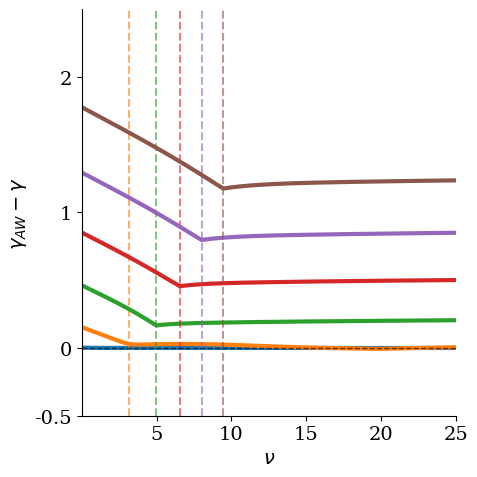

In [14]:
alpha=6
nu_HP = np.linspace(0.01, 25, 1000)

fig, ax = plt.subplots(ncols=1, figsize=(5, 5))

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=0.25, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.min(np.where(np.abs(eig_LB + 0.00216) < 1e-2))], color="tab:blue", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 0.00216, color="tab:blue", linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=0.5, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.min(np.where(np.abs(eig_LB + 0.1533) < 3e-2))], color="tab:orange", alpha=0.6, ls="--")
print(nu_HP[np.min(np.where(np.abs(eig_LB + 0.1533) < 3e-2))])
ax.plot(nu_HP, eig_LB + 0.1533, color="tab:orange", linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=0.75, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.argmin(np.abs(eig_LB + 0.461918))], color="tab:green", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 0.461918, color="tab:green",  linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=1, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.argmin(np.abs(eig_LB + 0.8513))], color="tab:red", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 0.8513, color="tab:red", linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=1.25, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.argmin(np.abs(eig_LB + 1.29386))], color="tab:purple", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 1.29386, color="tab:purple",linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = Hypercollisions_eig(k=1.5, nu=nu, Nv=Nv, alpha=alpha) 
ax.axvline(nu_HP[np.argmin(np.abs(eig_LB + 1.7757))], color="tab:brown", alpha=0.6, ls="--")
print(nu_HP[np.argmin(np.abs(eig_LB + 1.7757))])
ax.plot(nu_HP, eig_LB + 1.7757, color="tab:brown", linewidth=3)

ax.axhline(0, ls="--", color="black", linewidth=1, alpha=0.6)
ax.set_xlabel(r"$\nu$")
ax.set_yticks([-0.5, 0, 1, 2])
ax.set_yticklabels([-0.5, 0, 1, 2])
ax.set_ylabel(r"$\gamma_{AW} - \gamma $")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(-0.5, 2.5)

ax.set_xlim(np.min(nu_HP), np.max(nu_HP))
#legend = ax.legend(ncols=2, fancybox=False, shadow=False, fontsize=12,  bbox_to_anchor=(0.1, 1.))
#legend.get_frame().set_alpha(0)

plt.tight_layout()


plt.savefig("figs/spectra/optimal_hypercollisions_" + str(alpha) + "_nu_positive_k_Nv_" + str(Nv) + ".png", dpi=200, bbox_inches='tight')

2.5140080160320637
7.572104208416833


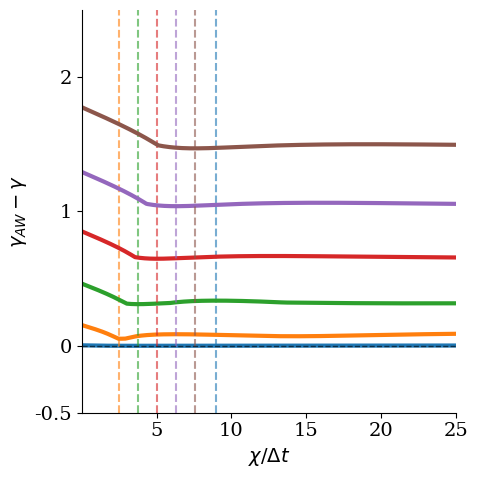

In [15]:
nu_HP = np.linspace(0.01, 25, 500)

fig, ax = plt.subplots(ncols=1, figsize=(5, 5))

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = HouLi_eig(k=0.25, nu=nu, Nv=Nv) 
ax.axvline(nu_HP[np.argmin(np.abs(eig_LB + 0.00216))], color="tab:blue", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 0.00216, color="tab:blue", linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = HouLi_eig(k=0.5, nu=nu, Nv=Nv) 
ax.axvline(nu_HP[np.argmin(np.abs(eig_LB + 0.1533))], color="tab:orange", alpha=0.6, ls="--")
print(nu_HP[np.argmin(np.abs(eig_LB + 0.1533))])
ax.plot(nu_HP, eig_LB + 0.1533, color="tab:orange", linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = HouLi_eig(k=0.75, nu=nu, Nv=Nv) 
ax.axvline(nu_HP[np.argmin(np.abs(eig_LB + 0.461918))], color="tab:green", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 0.461918, color="tab:green",  linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = HouLi_eig(k=1, nu=nu, Nv=Nv) 
ax.axvline(nu_HP[np.argmin(np.abs(eig_LB + 0.8513))], color="tab:red", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 0.8513, color="tab:red", linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = HouLi_eig(k=1.25, nu=nu, Nv=Nv) 
ax.axvline(nu_HP[np.argmin(np.abs(eig_LB + 1.29386))], color="tab:purple", alpha=0.6, ls="--")
ax.plot(nu_HP, eig_LB + 1.29386, color="tab:purple",linewidth=3)

eig_LB = np.zeros(len(nu_HP))
for ii, nu in enumerate(nu_HP):
    eig_LB[ii] = HouLi_eig(k=1.5, nu=nu, Nv=Nv) 
ax.axvline(nu_HP[np.argmin(np.abs(eig_LB + 1.7757))], color="tab:brown", alpha=0.6, ls="--")
print(nu_HP[np.argmin(np.abs(eig_LB + 1.7757))])
ax.plot(nu_HP, eig_LB + 1.7757, color="tab:brown", linewidth=3)

ax.axhline(0, ls="--", color="black", linewidth=1, alpha=0.6)
ax.set_xlabel(r"$\chi/ \Delta t$")
ax.set_yticks([-0.5, 0, 1, 2])
ax.set_yticklabels([-0.5, 0, 1, 2])
ax.set_ylabel(r"$\gamma_{AW} - \gamma $")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(-0.5, 2.5)

ax.set_xlim(np.min(nu_HP), np.max(nu_HP))
#legend = ax.legend(ncols=2, fancybox=False, shadow=False, fontsize=12,  bbox_to_anchor=(0.1, 1.))
#legend.get_frame().set_alpha(0)

plt.tight_layout()


plt.savefig("figs/spectra/optimal_HouLi_nu_positive_k_Nv_" + str(Nv) + ".png", dpi=200, bbox_inches='tight')